In [2]:
import netCDF4
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap, pyproj
#from JSAnimation.IPython_display import display_animation
from matplotlib import animation
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [5]:
hrrr_dap = netCDF4.Dataset('http://thredds-jumbo.unidata.ucar.edu/thredds/dodsC/grib/HRRR/CONUS_3km/wrfprs')

In [7]:
print(hrrr_dap.variables.keys())
print(hrrr_dap.variables['Temperature_isobaric'].shape)

[u'x', u'y', u'reftime', u'time', u'isobaric', u'LambertConformal_Projection', u'Cloud_ice_isobaric', u'Graupel_snow_pellets_isobaric', u'Specific_humidity_isobaric', u'Temperature_isobaric', u'Relative_humidity_isobaric', u'u-component_of_wind_isobaric', u'v-component_of_wind_isobaric', u'Geopotential_height_isobaric', u'Dewpoint_temperature_isobaric', u'Vertical_velocity_pressure_isobaric', u'Absolute_vorticity_isobaric', u'Cloud_mixing_ratio_isobaric', u'Rain_mixing_ratio_isobaric', u'Snow_mixing_ratio_isobaric']
(79, 16, 40, 1059, 1799)


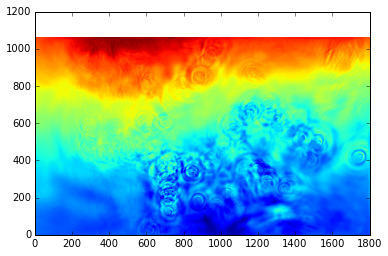

In [10]:
plt.pcolormesh(hrrr_dap.variables['Temperature_isobaric'][0,1,0,:,:])

In [8]:
print(hrrr_dap.ncattrs())

[u'Originating_or_generating_Center', u'Originating_or_generating_Subcenter', u'GRIB_table_version', u'Type_of_generating_process', u'file_format', u'Conventions', u'history', u'featureType', u'_CoordSysBuilder']


In [25]:
print(hrrr_dap.variables['LambertConformal_Projection'].ncattrs())

[u'grid_mapping_name', u'latitude_of_projection_origin', u'longitude_of_central_meridian', u'standard_parallel', u'earth_radius', u'_CoordinateTransformType', u'_CoordinateAxisTypes']


In [26]:
print(hrrr_dap.variables['x'].units)

km


In [27]:
def dap_lat_lons(open_dap_dataset, proj_key = 'LambertConformal_Projection'):
    xg, yg = np.meshgrid(open_dap_dataset.variables['x'][:]*1000.0, open_dap_dataset.variables['y'][:]*1000.0)
    pnyc = pyproj.Proj(proj = 'lcc', 
                       lat_1 = open_dap_dataset.variables[proj_key].latitude_of_projection_origin,
                       lat_2 = open_dap_dataset.variables[proj_key].latitude_of_projection_origin,
                       lat_0 = open_dap_dataset.variables[proj_key].latitude_of_projection_origin,
                       lon_0 = open_dap_dataset.variables[proj_key].longitude_of_central_meridian )
    return pnyc(xg, yg, inverse = True)
 

In [28]:
lon, lat = dap_lat_lons(hrrr_dap)

In [29]:
d11, d12 =  (np.abs(lat[:,0]-40)).argmin(), (np.abs(lat[:,0]-45)).argmin()
d21, d22 =  (np.abs(lon[0,:]+90)).argmin(), (np.abs(lat[0,:]+85)).argmin()

bbox = [d11, d12, d21, d22] 

<matplotlib.colorbar.Colorbar instance at 0x107c2c248>

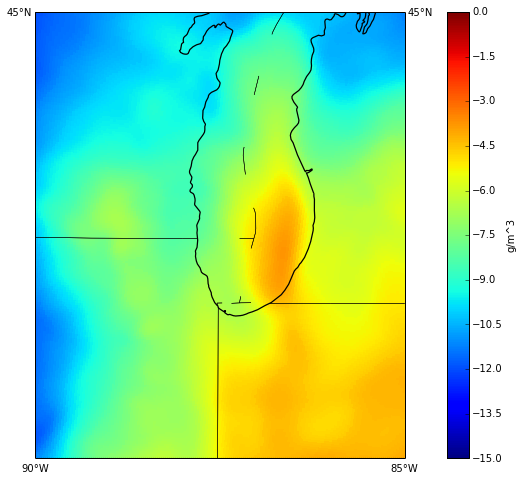

In [30]:
f = plt.figure(figsize = [15,8])
m = Basemap(llcrnrlon = -90,llcrnrlat = 40, urcrnrlon = -85,
               urcrnrlat = 45 , projection = 'mill', area_thresh =1000 ,
               resolution='h')
x, y = m(lon, lat)
my_mesh = m.pcolormesh(x, y, 
                       hrrr_dap.variables['Temperature_isobaric'][0,0,:,:]-273.15,
                       vmin = -15, vmax = 0)
my_coast = m.drawcoastlines(linewidth=1.25)
my_states = m.drawstates()
m.drawparallels(np.linspace(10,50, 9) ,labels=[1,1,0,0])
m.drawmeridians(np.linspace(-110, -80,7),labels=[0,0,0,1]) 
plt.colorbar(label='g/m^3')   

In [33]:
print x.shape

(1059, 1799)


In [34]:
def update(n, xx,yy,data,m, ax, bbox):
    plt.cla()
    my_mesh = m.pcolormesh( xx[bbox[0]:bbox[1],bbox[2]:bbox[3]], yy[bbox[0]:bbox[1],bbox[2]:bbox[3]], 
                       data.variables['Temperature_isobaric'][n,0,bbox[0]:bbox[1],bbox[2]:bbox[3]]-273.15,
                       vmin = -15, vmax = 0, ax = ax)
    my_coast = m.drawcoastlines(linewidth=1.25)
    my_states = m.drawstates()
    m.drawparallels(np.linspace(10,50, 9) ,labels=[1,1,0,0])
    m.drawmeridians(np.linspace(-110, -80,7),labels=[0,0,0,1]) 
    return my_mesh
    
    

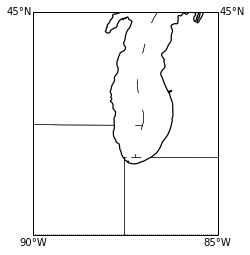

In [37]:
d11, d12 =  (np.abs(lat[:,0]-30)).argmin(), (np.abs(lat[:,0]-45)).argmin()
d21, d22 =  (np.abs(lon[0,:]+100)).argmin(), (np.abs(lat[0,:]+85)).argmin()

bbox = [d11, d12, d21, d22] 
f = plt.figure(figsize = [15,8])
m = Basemap(llcrnrlon = -90,llcrnrlat = 40, urcrnrlon = -85,
               urcrnrlat = 45 , projection = 'mill', area_thresh =1000 ,
               resolution='h')
x, y = m(lon, lat)
this_ax = f.add_axes([0.1, 0.1, .9, .8])
pc = update(0, x,y,hrrr_dap, m, this_ax, bbox)
plt.colorbar(label='T(C)', mappable = pc)   
my_anim = animation.FuncAnimation( f, update, fargs = (x,y,hrrr_dap, m, this_ax, bbox), 
                                  frames = 5 )
display_animation(my_anim, default_mode='once')